**Kernel berechenen für ein neuronales netz das ich mit flux erstellt habe**

In [1]:
using Flux
using Zygote
using PyPlot
using LinearAlgebra

#using Flux: train! , params
using Random

In [2]:
#Inizalisieren das modells (Input muss ein Vektor sein, auch für 1d)
width=100
input_dim = 2
output_dim = 1

model = Chain(
       Dense(input_dim, width,elu), # elu, so heißt die aktivierungsfunktion
       Dense(width, width,elu),
       Dense(width, output_dim)
)

ps = Flux.params(model);

In [47]:
#Initialisierungen für Kernelmethod

N_t = 15          # Wurzel der Anzahl der trainingsdaten, NT-Kernel hat dann N_t^4 Einträge
lam = 10^(-8)       #Parameter für ridge regression

#Inizialisieren der Trainingsdaten 
x_train = [ [ i j ] for i in range(-1,1, length=N_t), j in range(-1,1, length=N_t)] #Gitter
#x_train = reshape(x_train,(:,1))
         


#die Funktion, die gelernt werden soll

TrueFunction(x) = x[1]^2 + x[2]
y_train = [TrueFunction(vec(x_train[i])) for i in 1:length(x_train)];

In [48]:
#Transformation (Ein Vektor, meist höhere dimension als x)
#Gradient nach Theta vom modell
phi(x) = vcat(   [reshape(g,(:)) for g in jacobian(()->model(vec(x)), ps)]...   ) 

K(x,y) = phi(x)' *phi(y) + isapprox(x,y)*lam

#Berechnung des Kernels für die Trainingsdatenpunkte
NTK = Matrix{Float64}(undef,N_t^2,N_t^2)                        

for i in 1:N_t^2
    for j in 1:N_t^2
        
      NTK[i,j] =  K(vec(x_train[i]),vec(x_train[j]))
        
    end
end

#Vorhersage des Implizierten Modells
alpha = inv(NTK)*y_train    

function prediction(x_p)
    NTK_xp = Matrix{Float64}(undef,1,N_t^2)
    
    for i in 1:N_t^2        
      NTK_xp[i] =  K(x_p,vec(x_train[i]))
     end
    
return sum(NTK_xp*alpha) #So funktioniert es irgenwie nicht... :  sum([ K(x_p,vec((x_train)[i])) * alpha[i]  for i in N_t^2])
    #"sum() nur damit der Datentyp zu einem Float wird"
end

prediction (generic function with 1 method)

In [49]:
#Plotten

#  x1_range = range(-1,1, length=20) 
#  x2_range = range(-1,1, length=20)

 x1_range = range(-1,1, length=15) #testen auf trainingspunkten
 x2_range = range(-1,1, length=15)


 z_pred = zeros(length(x1_range),length(x1_range))   
 z_true = zeros(length(x1_range),length(x1_range))  

#z_pred = zeros(N_t,N_t)

#Werte Vorhersage
for i in 1:length(x1_range)
    for j in 1:length(x2_range)
        z_pred[i,j] = prediction([x1_range[i],x2_range[j]])
    end
end

#Werte für wahre Funktionswerte
for i in 1:length(x1_range)
    for j in 1:length(x2_range)
        z_true[i,j] = TrueFunction([x1_range[i],x2_range[j]])
    end
end

#2D nur die Punkte Plotten?


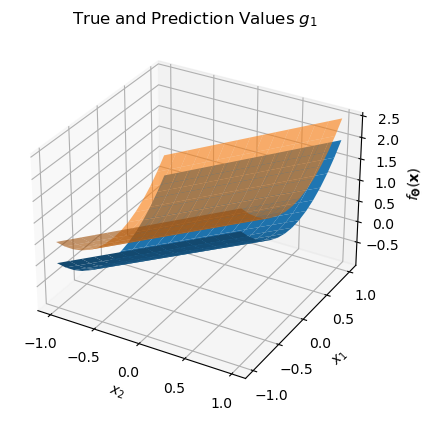

In [50]:
surf(x1_range,x2_range,z_pred, alpha=1);

#Echte Werte
surf(x1_range,x2_range,z_true .+0.5, alpha=0.6);

xlabel(L"x_2") 
ylabel(L"x_1")
zlabel(L"f_{\mathbf{\Theta}}(\mathbf{x})")
title(L"\mathrm{True\; and\; Prediction \;Values}\;g_1")

#save plot with good enougt dpi
plt.savefig("IMG/NTK Example g1 on N_tr",dpi=400)